# Wrangling the Xarray datasets of ERA5 data
- Creating subsets based on used grid points 
- Deriving data vars mean wind speed and wind direction
- Combining the subsetted datasets? (or treat each year separately?)

In [82]:
from pathlib import Path
from itertools import product
import math

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

In [3]:
# Directory where data files will be downloaded
cwd_path = Path.cwd()
data_path = cwd_path.parent.joinpath('data')
data_push_path = cwd_path.parent.joinpath('data_to_push')

In [4]:
# Load the NetCDF file using Xarray
ds = xr.open_dataset(data_path.joinpath('wind_data.nc'))

In [6]:
ds

<xarray.Dataset>
Dimensions:    (longitude: 52, latitude: 42, time: 8760)
Coordinates:
  * longitude  (longitude) float32 4.22 4.47 4.72 4.97 ... 16.47 16.72 16.97
  * latitude   (latitude) float32 56.32 56.07 55.82 55.57 ... 46.57 46.32 46.07
  * time       (time) datetime64[ns] 2022-01-01 ... 2022-12-31T23:00:00
Data variables:
    u100       (time, latitude, longitude) float32 ...
    v100       (time, latitude, longitude) float32 ...
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-08-27 18:02:49 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

---

## Derive mean wind speed data variable

#### Helper function to calculate wind speed using zonal and meridional components

In [7]:
def calc_wind_speed_using_ortho_components(u_zonal, v_meridional):
    """
    u_zondal (u10): wind component along local parallel of latitude; positive from west, negative from east
    v_meridional (v10): wind component along local meridian; positive from south, negative from north
    """
    # use numpy.sqrt() as math.sqrt() only accepts scalar value not array
    mean_wind_speed = np.sqrt(u_zonal**2 + v_meridional**2)
    return mean_wind_speed

In [8]:
# Apply the calc wind speed function and assign to dataset as a new data variable 
ds['mean_wind_speed_10m'] = xr.apply_ufunc(calc_wind_speed_using_ortho_components, ds['u10'], ds['v10'])

In [9]:
ds

<xarray.Dataset>
Dimensions:              (longitude: 52, latitude: 42, time: 8760)
Coordinates:
  * longitude            (longitude) float32 4.22 4.47 4.72 ... 16.72 16.97
  * latitude             (latitude) float32 56.32 56.07 55.82 ... 46.32 46.07
  * time                 (time) datetime64[ns] 2022-01-01 ... 2022-12-31T23:0...
Data variables:
    u100                 (time, latitude, longitude) float32 ...
    v100                 (time, latitude, longitude) float32 ...
    u10                  (time, latitude, longitude) float32 9.286 ... 3.102
    v10                  (time, latitude, longitude) float32 1.064 ... 3.552
    mean_wind_speed_10m  (time, latitude, longitude) float32 9.347 ... 4.716
Attributes:
    Conventions:  CF-1.6
    history:      2023-08-27 18:02:49 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

##### Get mean wind speed at specific hour and coordinate 

In [31]:
# Example used grid point: (47.82, 10.97)
ds.sel(time=['2022-01-01T00:00:00'], latitude=47.82, longitude=10.97)['mean_wind_speed_10m'].values

array([3.1660938], dtype=float32)

-----

## Derive wind direction data variable

#### Calculate wind direction in degrees
- Since this isn't really a continuous variable for ML regression, also convert to descriptive categorical variable!
- Remember that the degree angle indicates where the wind blows FROM not to!

#### Function to calculate wind direction in degrees

In [102]:
def calc_wind_direction_using_ortho_components(u_zonal, v_meridional):
    # Wind direction in radians
    theta_rad = math.atan2(-u_zonal, -v_meridional)
    
    # Convert radians to degrees
    theta_deg = math.degrees(theta_rad)
    
    # Normalize to [0, 360)
    if theta_deg < 0:
        theta_deg += 360
    
    return theta_deg

In [103]:
# Example:
u = 9
v = 2
wind_direction = calc_wind_direction_using_ortho_components(u, v)
print(f"Wind direction: {wind_direction}°")

Wind direction: 257.4711922908485°


#### Function to return the inter-cardinal direction using wind direction degree angle
- For 16 inter-cardinal directions the degree range of each is:
    - 360°/16 = 22.5° (Option-Shift-8 to insert degree symbol)
    - 360°/0° is true north
    - Boundaries are 11.25° in both directions from the true direction heading
        - 0° to 11.25° is N (North)
- I'm using the following inter-cardinal directions:
    - N (North)
    - NNE (North-Northeast)
    - NE (Northeast)
    - ENE (East-Northeast)
    - E (East)
    - ESE (East-Southeast)
    - SE (Southeast)
    - SSE (South-Southeast)
    - S (South)
    - SSW (South-Southwest)
    - SW (Southwest)
    - WSW (West-Southwest)
    - W (West)
    - WNW (West-Northwest)
    - NW (Northwest)
    - NNW (North-Northwest)

In [104]:
def wind_direction_to_intercardinal(wind_direction_degrees):
    # Make sure value is between 0-360 using modulo python assignment operator %= (same as x = x % 360)
    # If 380 --> 20 degrees (starts back at 0 at 360)
    wind_direction_degrees %= 360
    
    # The 16 intercardinal directions and their corresponding ranges spanning 22.5 degrees each
    # Note: the boundaries are 11.25 in both directions from the direction's true centre line, creating a sector
    intercardinal_directions = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW', 'N']
    boundaries = [11.25, 33.75, 56.25, 78.75, 101.25, 123.75, 146.25, 168.75, 191.25, 213.75, 236.25, 258.75, 281.25, 303.75, 326.25, 348.75, 360]

    # Loop through boundaries and return first direction at index i that satisfies the condition
    for i in range(len(boundaries)):
        if wind_direction_degrees < boundaries[i]:
            return intercardinal_directions[i]

In [105]:
# Example:
wind_dir = 244
category = wind_direction_to_intercardinal(wind_dir)
print(f"Wind direction: {wind_dir}° is {category}")

Wind direction: 244° is WSW


In [106]:
np.linspace(11.25, 360, 9)

array([  0.,  45.,  90., 135., 180., 225., 270., 315., 360.])

In [80]:
# def calculate_boundaries():
#     # Total of 8 directions, each spanning 45 degrees
#     boundaries = [i * 45 for i in range(8)]

#     # Append 360 to close the loop for North
#     boundaries.append(360)

#     return boundaries

In [62]:
calculate_boundaries()

[0, 45, 90, 135, 180, 225, 270, 315, 360]

In [81]:
wind_direction_degrees = 244

# The 8 intercardinal directions and corresponding boundary ranges spanning 45 degrees each
intercardinal_directions = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW', 'N']
boundaries = [11.25, 33.75, 56.25, 78.75, 101.25, 123.75, 146.25, 168.75, 191.25, 213.75, 236.25, 258.75, 281.25, 303.75, 326.25, 348.75, 360]

# Determine the intercardinal direction based on the degree value
for i in range(len(boundaries)):
    print(i)
    print(boundaries[i])
    if wind_direction_degrees < boundaries[i]:
        print(boundaries[i])
        print(intercardinal_directions[i])
        break

0
11.25
1
33.75
2
56.25
3
78.75
4
101.25
5
123.75
6
146.25
7
168.75
8
191.25
9
213.75
10
236.25
11
258.75
258.75
WSW


In [96]:
def plot_wind_rose():
    # Define the categories and boundaries
    categories = ["N", "NNE", "NE", "ENE", "E", "ESE", "SE", "SSE", "S", "SSW", "SW", "WSW", "W", "WNW", "NW", "NNW"]
    boundaries = np.linspace(0, 360, 17)[:-1]  # We exclude the last boundary (360) for labeling purposes

    # Set up a figure and axis with polar projection
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': 'polar'})

    # Set the direction of azimuthal labels
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)  # Clockwise

    # Set the radius labels
    ax.set_rticks([])  # Turn off radial labels
    ax.set_rlabel_position(180)

    # Set the circular labels (directions)
    ax.set_xticks(np.radians(boundaries))
    ax.set_xticklabels(categories)

    # Plot each section with a simple color for demonstration
    for boundary in boundaries:
        ax.fill_between([np.radians(boundary-11.25), np.radians(boundary+11.25)], 0, 1, alpha=0.2)
    
    plt.title("Wind Rose with 16 Intercardinal Directions")
    plt.show()

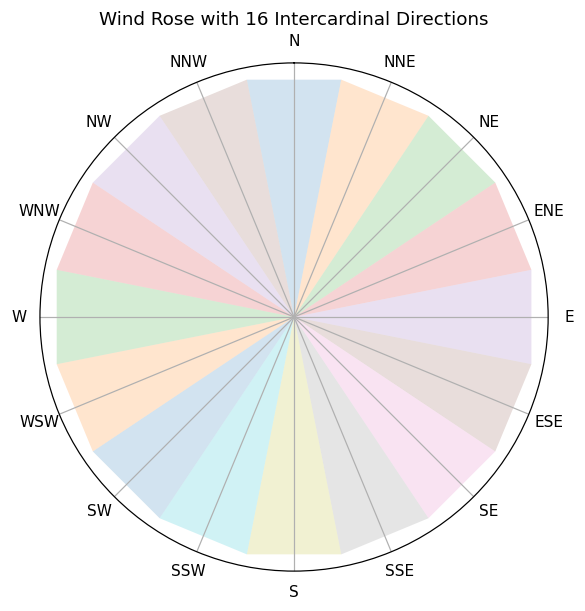

In [97]:
plot_wind_rose()